# MExGen for Summarization

This notebook walks through an example of using MExGen (Multi-Level Explanations for Generative Language Models) to explain an LLM's summarization of a document. For more information on MExGen, please see the [paper](https://aclanthology.org/2025.acl-long.1553/).

After setting things up in Section 1, we will obtain explanations in the form of sentence-level attributions to the input document in Section 2, followed by mixed phrase- and sentence-level attributions in Section 3. We will then evaluate the fidelity of these explanations to the LLM in Section 4.

## 1. Setup

### Import packages

Standard packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

from datasets import load_dataset    # for XSum dataset
import matplotlib.pyplot as plt    # for plotting perturbation curves
import numpy as np
from openai import OpenAI    # for VLLM summarization model
import pandas as pd    # only for displaying DataFrames
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BartForConditionalGeneration, BartTokenizerFast    # for HuggingFace summarization models

ICX360 classes

In [2]:
from icx360.algorithms.mexgen import CLIME, LSHAP    # explainers
from icx360.metrics import PerturbCurveEvaluator    # fidelity evaluation
from icx360.utils.coloring_utils import color_units    # highlight and display text
from icx360.utils.general_utils import select_device    # set device automatically
from icx360.utils.model_wrappers import HFModel, VLLMModel    # model wrappers

In [3]:
device = select_device()
device

device(type='cuda')

### Load model to explain

Here you can choose from the following models:
- `"distilbart"`: A small summarization model from HuggingFace
- `"granite-hf"`: A larger model from HuggingFace
- `"vllm"`: A model served using VLLM. This is a "bring your own model" option, for which you will have to supply the parameters below (`model_name`, `base_url`, `api_key`, and any others).

In [4]:
# model_type = "distilbart"
model_type = "granite-hf"
# model_type = "vllm"

In [5]:
if model_type == "distilbart":
    model_name = "sshleifer/distilbart-xsum-12-6"
    model = BartForConditionalGeneration.from_pretrained(model_name).to(device)
    tokenizer = BartTokenizerFast.from_pretrained(model_name, add_prefix_space=True)

elif model_type == "granite-hf":
    model_name = "ibm-granite/granite-3.3-2b-instruct"
    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16).to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

elif model_type == "vllm":
    # IF YOU HAVE A VLLM MODEL, UNCOMMENT AND REPLACE THE FOLLOWING LINES WITH YOUR MODEL'S PARAMETERS
    # base_url = "https://YOUR/MODEL/URL"
    # api_key = YOUR_API_KEY
    # openai_kwargs = {}
    model = OpenAI(api_key=api_key, base_url=base_url, **openai_kwargs)
    # Corresponding HuggingFace tokenizer for applying chat template
    # model_name = "YOUR/MODEL-NAME"
    # tokenizer_kwargs = {}
    tokenizer = AutoTokenizer.from_pretrained(model_name, **tokenizer_kwargs)

else:
    raise ValueError("Unknown model type")

Loading checkpoint shards: 100%|██████████████████████████████████████| 2/2 [00:09<00:00,  4.51s/it]


We then wrap the model with a common API (`HFModel` or `VLLMModel`) that the explainer will use.

In [6]:
if model_type in ("distilbart", "granite-hf"):
    wrapped_model = HFModel(model, tokenizer)
elif model_type == "vllm":
    wrapped_model = VLLMModel(model, model_name, tokenizer)

### Load input

Load the Extreme Summarization (XSum) dataset

In [7]:
#dataset = load_dataset('xsum', split='train', trust_remote_code=True)
dataset = load_dataset('xsum', split='test', trust_remote_code=True)

For this example, we will find a news article about the clothing retailer Inditex. This can be modified to load a different article.

In [8]:
for document in dataset["document"]:
    if "The world's biggest clothing retailer" in document:
        break
print(document)

The world's biggest clothing retailer posted net earnings of €1.26bn (£1.1bn) in the six months to 31 July - up 8% on the same period last year.
Sales jumped from €9.4bn to €10.5bn, an increase of 11%.
The group's clothes can now be bought online in around 40 countries, it said.
Inditex operates eight brands in 90 countries including Pull&Bear, Massimo Dutti and Bershka.
How Zara's founder became the richest man in the world - for two days
Chairman and chief executive Pablo Isla emphasised the firm's investment in technology, saying the firm had expanded its online stores to 11 new countries in the period.
It also launched mobile phone payment in all its Spanish stores, with the objective of "extending the service to other countries".
This will encompass online apps for all of its brands and a specific app for the whole group called InWallet.
Mr Isla said: "Both our online and bricks-and-mortar stores are seamlessly connected, driven by platforms such as mobile payment, and other techn

### Generate model response

As a check on our setup, we will have the model generate its summary of the input document, via the `wrapped_model` object created above.

First we specify parameters for model generation, as a dictionary `model_params`. These parameters include `max_new_tokens`/`max_tokens`, whether to use the model's chat template, and any instruction provided as a system prompt (the DistilBART model does not need an instruction to summarize).

In [9]:
model_params = {}
if model_type == "vllm":
    model_params["max_tokens"] = 100
    model_params["seed"] = 20250430
else:
    model_params["max_new_tokens"] = 100
    
if model_type in ("granite-hf", "vllm"):
    model_params["chat_template"] = True
    model_params["system_prompt"] = "Summarize the following article in one sentence. Do not preface the summary with anything."

model_params

{'max_new_tokens': 100,
 'chat_template': True,
 'system_prompt': 'Summarize the following article in one sentence. Do not preface the summary with anything.'}

Now we generate the summary:

In [10]:
output_orig = wrapped_model.generate(document, text_only=False, **model_params)
print(output_orig.output_text)

[' Inditex, the parent company of Zara, reported a 8% increase in net earnings to €1.26bn and a 11% rise in sales to €10.5bn for the six months ending 31 July, driven by an 8% online growth and expansion into 11 new countries, with plans to extend mobile payment services globally, while benefiting from steady economic growth in Spain and expanding intern']


## 2. Sentence-Level Explanation

### Instantiate explainer

Here you can choose between two attribution algorithms used by MExGen, C-LIME and L-SHAP. These are more efficient variants of LIME and SHAP respectively. In either case, the explanation takes the form of importance scores assigned to parts of the input document, and these scores are computed by calling the summarization model on perturbed versions of the input. 

In [11]:
# explainer_alg = "clime"
explainer_alg = "lshap"

if explainer_alg == "clime":
    explainer_class = CLIME
elif explainer_alg == "lshap":
    explainer_class = LSHAP

The primary parameter for the explainer is the "scalarizer", which quantifies how different are the output summaries for perturbed inputs from the output summary for the original input. For this we will use "text-only" scalarizers (`scalarizer="text"`), which compute different similarity scores between the original summary and the perturbed summaries, thus providing different views of what constitutes "similarity". Small language models are used to provide these similarity scores. Specifically, we use an NLI model to compute both NLI scores and BERTScores, and a summarization model (same as the DistilBART model above) to compute "SUMM" scores and BARTScores.

In [12]:
model_nli_name = "microsoft/deberta-v2-xxlarge-mnli"
model_summ_name = "sshleifer/distilbart-xsum-12-6"

explainer = explainer_class(wrapped_model, scalarizer="text", 
                            model_nli=model_nli_name, model_bert=model_nli_name,
                            model_summ=model_summ_name, model_bart=model_summ_name, device=device)

### Call explainer

To explain the summary that was generated above, we call the explainer's `explain_instance` method, passing to it the input document, summary `output_orig`, model generation parameters in `model_params`, and default settings otherwise. This will segment the document into sentences and attribute an importance score to each sentence.

In [13]:
output_dict_sent = explainer.explain_instance(document, output_orig=output_orig, model_params=model_params)

toma_generate batch size = 132


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[' Inditex, the parent company of Zara, reported a 8% increase in net earnings to €1.26bn and a 11% rise in sales to €10.5bn for the six months ending 31 July, driven by an 8% online growth and expansion into 11 new countries, with plans to extend mobile payment services globally, while benefiting from steady economic growth in Spain and expanding intern']
[' Inditex, the parent company of Zara, reported a 8% increase in net earnings to €1.26bn and a 11% rise in sales to €10.5bn for the six months ending 31 July, driven by an online drive, expansion into 11 new countries, and seamless integration of online and physical stores, with plans to further develop technological initiatives.', ' Inditex, the parent company of Zara, reported a 8% increase in net earnings to €1.26bn for the first half of its fiscal year, driven by a 11% rise in sales to €10.5bn, with significant growth in online sales and expansion into 11 new countries, under the strategic leadership of Chairman Pablo Isla who e

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


toma_get_probs batch size = 132


### Look at output

The explainer returns a dictionary. The `"output_orig"` item shows the output summary for the original document, i.e., the summary generated above.

In [14]:
output_dict_sent["output_orig"].output_text

[' Inditex, the parent company of Zara, reported a 8% increase in net earnings to €1.26bn and a 11% rise in sales to €10.5bn for the six months ending 31 July, driven by an 8% online growth and expansion into 11 new countries, with plans to extend mobile payment services globally, while benefiting from steady economic growth in Spain and expanding intern']

The `"attributions"` item is itself a dictionary, containing the sentences (`"units"`) that the document has been split into, the corresponding `"unit_types"`, and the importance scores for the sentences, one score for each similarity metric included in the scalarizer (NLI, BERTScore, etc.). We organize these scores into a pandas DataFrame and display them first as highlighted text, where we sum the scores across similarity metrics to show a single version.

In [15]:
attrib_scores_df = pd.DataFrame(output_dict_sent["attributions"]).set_index("units")
score_labels = explainer.scalarized_model.sim_scores
attrib_scores_df = attrib_scores_df[["unit_types"] + score_labels]

color_units(output_dict_sent["attributions"]["units"], attrib_scores_df[score_labels].sum(axis=1))

We then display the pandas DataFrame to show the numerical scores for all similarity metrics, where we also normalize each column of scores by the maximum score.

In [16]:
attrib_scores_df[score_labels] /= attrib_scores_df[score_labels].max(axis=0)
attrib_scores_df

,unit_types,nli_logit,bert,st,summ,bart
units,,,,,,
The world's biggest clothing retailer posted net earnings of €1.26bn (£1.1bn) in the six months to 31 July - up 8% on the same period last year.,s,1.000000,1.000000,1.000000,1.000000,1.000000
"\nSales jumped from €9.4bn to €10.5bn, an increase of 11%.",s,-0.759372,0.209952,0.113165,0.178240,0.243746
"\nThe group's clothes can now be bought online in around 40 countries, it said.",s,-0.808849,0.178138,0.047222,0.768345,0.806839
"\nInditex operates eight brands in 90 countries including Pull&Bear, Massimo Dutti and Bershka.",s,0.879383,0.231298,0.547190,0.295272,0.324798
"\nHow Zara's founder became the richest man in the world - for two days\nChairman and chief executive Pablo Isla emphasised the firm's investment in technology, saying the firm had expanded its online stores to 11 new countries in the period.",s,0.576931,0.249219,0.383890,0.053929,-0.008015
"\nIt also launched mobile phone payment in all its Spanish stores, with the objective of ""extending the service to other countries"".",s,0.159763,0.135365,0.276763,0.055919,0.058838
\nThis will encompass online apps for all of its brands and a specific app for the whole group called InWallet.,s,-0.421199,0.041748,-0.082515,0.004378,-0.014728
"\nMr Isla said: ""Both our online and bricks-and-mortar stores are seamlessly connected, driven by platforms such as mobile payment, and other technological initiatives that we will continue to develop.""",s,-0.173751,0.112717,0.356537,0.182602,0.122337
"\nTom Gadsby, an analyst at Liberum, said the firm's ""online drive"" was important.",s,-0.974988,0.123459,-0.272267,0.156446,0.170738


While the importance scores should align roughly with our human intuition (for example, sentences mentioning increases in earnings, sales, and online presence are important), we will defer to Section 4 the evaluation of how faithful they are to the summarization LLM.

## 3. Mixed Phrase- and Sentence-Level Explanation

We will now consider the multi-level aspect of MExGen by obtaining mixed phrase- and sentence-level attributions to the input document.

### Set up parameters

For this illustration, we will segment the 2 most important sentences (as determined in the previous section) into phrases. (This number can be changed.) We will also measure importance by the sum of scores across the similarity metrics (a single similarity metric could be used too).

In [17]:
num_top_sent = 2
score_label = "sum"

The parameters for `explain_instance()` will be as follows:
- `units` and `unit_types`: Take existing sentence-level units and unit types from `output_dict_sent["attributions"]`
- `output_orig` same as above
- `ind_segment`: We create a Boolean array that has value `True` in positions corresponding to the top 2 sentences in terms of the sum of scores, and `False` otherwise. This will tell the explainer to segment only these 2 sentences.
- `segment_type = "ph"` for segmentation into phrases
- `model_params` as before

In [18]:
units = output_dict_sent["attributions"]["units"]
unit_types = output_dict_sent["attributions"]["unit_types"]
segment_type = "ph"

if score_label == "sum":
    scores = attrib_scores_df[score_labels].sum(axis=1).values
else:
    scores = attrib_scores_df[score_label].values

ind_segment = np.zeros_like(scores, dtype=bool)
ind_segment[np.argsort(scores)[-num_top_sent:]] = True
ind_segment

array([ True, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

### Call explainer

Now we call `explain_instance()` with the above parameters

In [19]:
output_dict_mixed = explainer.explain_instance(units, unit_types, output_orig=output_orig, ind_segment=ind_segment, segment_type=segment_type, model_params=model_params)

Subtree ['eight', 'brands', 'including', 'Pull&Bear', ',', 'Massimo', 'Dutti', 'and', 'Bershka'] not contiguous!
toma_generate batch size = 204
[' Inditex, the parent company of Zara, reported a 8% increase in net earnings to €1.26bn and a 11% rise in sales to €10.5bn for the six months ending 31 July, driven by an 8% online growth and expansion into 11 new countries, with plans to extend mobile payment services globally, while benefiting from steady economic growth in Spain and expanding intern']
[' Inditex, the parent company of Zara, reported a 8% increase in net earnings to €1.26bn and a 11% rise in sales to €10.5bn for the six months ending 31 July, driven by an online drive, expansion into 11 new countries, and steady economic growth in Spain, outpacing European rivals H&M and Next.', " Zara, the world's largest clothing retailer, reported a 8% increase in net earnings to €1.26bn, driven by robust online sales and expansion into 11 new countries, with plans to roll out mobile pay

### Look at output

Output summary for the original document

In [20]:
output_dict_mixed["output_orig"].output_text

[' Inditex, the parent company of Zara, reported a 8% increase in net earnings to €1.26bn and a 11% rise in sales to €10.5bn for the six months ending 31 July, driven by an 8% online growth and expansion into 11 new countries, with plans to extend mobile payment services globally, while benefiting from steady economic growth in Spain and expanding intern']

Mixed phrase- and sentence-level importance scores, first summed across similarity metrics and visualized as highlighted text:

In [21]:
attrib_scores_df = pd.DataFrame(output_dict_mixed["attributions"]).set_index("units")
attrib_scores_df = attrib_scores_df[["unit_types"] + score_labels]

color_units(output_dict_mixed["attributions"]["units"], attrib_scores_df[score_labels].sum(axis=1))

Importance scores using each similarity metric, again normalized by the maximum score:

In [22]:
attrib_scores_df[score_labels] /= attrib_scores_df[score_labels].max(axis=0)
attrib_scores_df

,unit_types,nli_logit,bert,st,summ,bart
units,,,,,,
The world's biggest clothing retailer,nsubj,-0.442970,-0.099926,-0.059958,-0.240193,-0.183453
posted,ROOT,-0.129547,0.197238,-0.099478,0.060759,0.089610
net earnings of €1.26bn (£1.1bn),dobj,-1.556081,0.978237,0.548432,1.000000,1.000000
in the six months to 31 July,prep,0.368621,0.419872,-0.044429,-0.088184,-0.020920
-,n,0.000000,0.000000,0.000000,0.000000,0.000000
up 8% on the same period last year,advmod,0.825911,1.000000,0.480190,0.721515,0.632897
.,n,0.000000,0.000000,0.000000,0.000000,0.000000
"\nSales jumped from €9.4bn to €10.5bn, an increase of 11%.",s,-2.082431,-0.035347,-0.186891,-0.014012,0.041359
"\nThe group's clothes can now be bought online in around 40 countries, it said.",s,-1.848802,0.252483,-0.152765,0.877237,0.802476


## 4. Evaluate fidelity of attributions to explained model

We now evaluate the fidelity of both the sentence-level and mixed-level explanations to the behavior of the summarization model. We do this by computing *perturbation curves*. Given a set of attribution scores, the perturbation curve measures how much the output summary changes as we remove more and more units from the input document, in decreasing order of importance according to the scores.

### Instantiate perturbation curve evaluator

We instantiate a `PerturbCurveEvaluator` to compute perturbation curves. Similar to the explainer, `PerturbCurveEvaluator` requires a scalarizer to quantify how much the output summary changes from the original summary as more input units are removed. Here we use a **different** scalarizer than those used in the explainer, namely the `"prob"` scalarizer, which computes the probability of generating the original summary conditioned on perturbed inputs.

In [23]:
evaluator = PerturbCurveEvaluator(wrapped_model, scalarizer="prob")

### Evaluate perturbation curves

We call the `eval_perturb_curve` method to compute perturbation curves for both sentence-level and mixed-level attribution scores and for all scores obtained with the different similarity metrics in the explanation scalarizer (NLI score, BERTScore, etc.). Parameters for `eval_perturb_curve` are as follows:
- `output_dict_sent` or `output_dict_mixed`: The dictionary returned by the explainer
- `score_label`: The score label corresponding to each similarity metric
- `token_frac=True`: This setting allows comparison between different kinds of units (sentences vs. mixed) because it takes into account the number of tokens in each unit, which is considered as the length of the unit and in ranking units.
- `model_params`: The same model generation parameters as before

In [24]:
perturb_curve = {"sent": {}, "mixed": {}}

for score_label in score_labels:
    perturb_curve["sent"][score_label] = evaluator.eval_perturb_curve(output_dict_sent, score_label, token_frac=True, model_params=model_params)
    perturb_curve["mixed"][score_label] = evaluator.eval_perturb_curve(output_dict_mixed, score_label, token_frac=True, model_params=model_params)

toma_get_probs batch size = 9
toma_get_probs batch size = 14
toma_get_probs batch size = 11
toma_get_probs batch size = 16
toma_get_probs batch size = 2
toma_get_probs batch size = 9
toma_get_probs batch size = 15
toma_get_probs batch size = 11
toma_get_probs batch size = 16
toma_get_probs batch size = 1
toma_get_probs batch size = 11
toma_get_probs batch size = 16
toma_get_probs batch size = 1


### Plot perturbation curves

The perturbation curves are plotted below as a function of the fraction of tokens removed from the input. The y-axis is the decrease in the log probability of generating the original summary, computed by the scalarizer of `PerturbCurveEvaluator`.

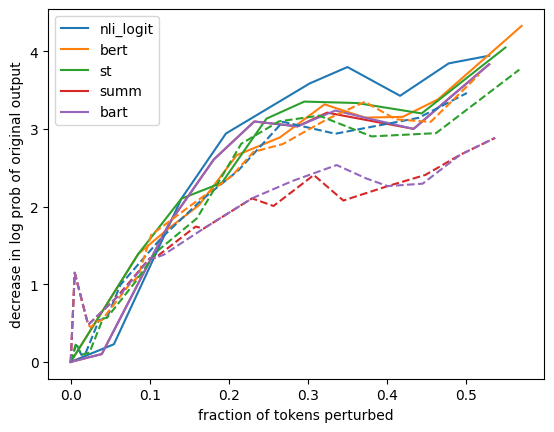

In [25]:
# Sentence-level perturbation curves
line = {}
for score_label in score_labels:
    df = pd.DataFrame(perturb_curve["sent"][score_label]).set_index("frac")
    line[score_label], = plt.plot(df.loc[0] - df)

# Mixed-level perturbation curves
for score_label in score_labels:
    df = pd.DataFrame(perturb_curve["mixed"][score_label]).set_index("frac")
    plt.plot(df.loc[0] - df, color=line[score_label].get_color(), linestyle="--")

plt.xlabel("fraction of tokens perturbed")
plt.ylabel("decrease in log prob of original output")
plt.legend(score_labels)

In general, we are looking for perturbation curves to increase as more tokens are removed from the input. A higher perturbation curve is better because it indicates that the units identified by the explanation as important actually do have a larger effect on the LLM's output, and hence the explanation is more faithful to the LLM. 

Some observations from this single example (your results may vary, and it is difficult to generalize from a single example): Sentence-level attribution scores (solid curves) perform about as well as mixed-level scores (dashed curves), and in some cases are better. There is no separation or clear ordering among the 5 similarity metrics. `"summ"`, and `"bart"` tend to be most similar to each other.